In [ ]:
import torch
# import tenseal as ts
import pandas as pd
import time

from sklearn.metrics import r2_score, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import pickle
import seaborn as sns
from openfhe import *
from tqdm import tqdm

Setul de date este luat din kaggle: https://www.kaggle.com/datasets/mahatiratusher/stroke-risk-prediction-dataset-v2/data

In [ ]:
# def prelucrare_date():
#     csv = pd.read_csv('./stroke_risk_dataset.csv', encoding='utf-8')
#     csv = csv.drop(columns=["nausea_vomiting"])
#     gender = ['Male','Female']
#     dict_gender = {t: i + 1 for i, t in enumerate(gender)}
#     csv['gender'] = csv['gender'].map(dict_gender).fillna(-1).astype(int)
#     #impartim datle pentru linear regression si logistic regression in date de train si test
#     li_r_labels = torch.tensor(csv["stroke_risk_percentage"].values).float().unsqueeze(1)
#     lo_r_labels = torch.tensor(csv["at_risk"].values).float().unsqueeze(1)
#     # print(li_r_labels)
#     # print(lo_r_labels)
#     li_r_data = csv.drop(columns=["stroke_risk_percentage", "at_risk"])
#     lo_r_data = csv.drop(columns=["stroke_risk_percentage", "at_risk"])
#     # print(li_r_data)
#     # print(lo_r_data)
#     li_r_data = torch.tensor(li_r_data.values).float()
#     lo_r_data = torch.tensor(lo_r_data.values).float()
#     li_r_data, li_r_labels = shuffle(li_r_data, li_r_labels, random_state=0)
#     lo_r_data, lo_r_labels = shuffle(lo_r_data, lo_r_labels, random_state=0)
#     li_r_train_data, li_r_test_data, li_r_train_labels, li_r_test_labels = train_test_split(
#         li_r_data, li_r_labels, test_size=0.3, random_state=0)
#     lo_r_train_data, lo_r_test_data, lo_r_train_labels, lo_r_test_labels = train_test_split(
#         lo_r_data, lo_r_labels, test_size=0.3, random_state=0)
#     return li_r_train_data, li_r_test_data, li_r_train_labels, li_r_test_labels,lo_r_train_data, lo_r_test_data, lo_r_train_labels, lo_r_test_labels

In [ ]:
# li_r_train_data, li_r_test_data, li_r_train_labels, li_r_test_labels,lo_r_train_data, lo_r_test_data, lo_r_train_labels, lo_r_test_labels=prelucrare_date()
# torch.save({
#     'train_data': li_r_train_data,
#     'test_data': li_r_test_data,
#     'train_labels': li_r_train_labels,
#     'test_labels': li_r_test_labels
# }, 'date_liniar_regression.pth')
# torch.save({
#     'train_data': lo_r_train_data,
#     'test_data': lo_r_test_data,
#     'train_labels': lo_r_train_labels,
#     'test_labels': lo_r_test_labels
# }, 'date_logistic_regression.pth')

In [ ]:
def incarcare_date(path):
    date_salvate = torch.load(path,weights_only=True)
    x_train = date_salvate['train_data']
    x_test = date_salvate['test_data']
    y_train = date_salvate['train_labels']
    y_test = date_salvate['test_labels']
    print("############# Data summary #############")
    print(f"x_train has shape: {x_train.shape}")
    print(f"y_train has shape: {y_train.shape}")
    print(f"x_test has shape: {x_test.shape}")
    print(f"y_test has shape: {y_test.shape}")
    print("#######################################")
    return x_train,x_test,y_train,y_test

In [ ]:
def normalizare_date(x_train,x_test,y_train,y_test):
    scaler = StandardScaler()
    x_train = torch.tensor(scaler.fit_transform(x_train), dtype=torch.float32)
    x_test= torch.tensor(scaler.transform(x_test), dtype=torch.float32)
    print(x_train.shape)
    print(x_test.shape)
    y_train = torch.tensor(scaler.fit_transform(y_train), dtype=torch.float32)
    y_test = torch.tensor(scaler.transform(y_test), dtype=torch.float32)
    return x_train,x_test,y_train,y_test


In [382]:
x_train,x_test,y_train,y_test = incarcare_date('date_liniar_regression.pth')
x_train,x_test,y_train,y_test = normalizare_date(x_train,x_test,y_train,y_test)
x_train,x_test,y_train,y_test= x_train[:1000],x_test[:700],y_train[:1000],y_test[:700]
#vom lucra doar cu o parte din setul de date pentru a antrena mai repede modelul,
#  deoarce nu ne intereseaza acuratetea modelului 

############# Data summary #############
x_train has shape: torch.Size([24500, 16])
y_train has shape: torch.Size([24500, 1])
x_test has shape: torch.Size([10500, 16])
y_test has shape: torch.Size([10500, 1])
#######################################
torch.Size([24500, 16])
torch.Size([10500, 16])


In [383]:
class LinearRegressionFromScratch:
    def __init__(self, n_features, learning_rate=1e-2, weight_decay=0.01):
        self.bound = np.sqrt(3/n_features)
        self.weight = torch.tensor([0.01]*16)
        # self.weight =  torch.tensor(np.random.uniform(-self.bound, self.bound, size=n_features))
        self.bias = torch.tensor([0.000])
        self.learning_rate = learning_rate
        self.weight_decay = weight_decay
        self._delta_w = 0
        self._delta_b = 0
       
    def forward(self, x_data):
        #enc_x este un batch de date, shape : b,n_features
        return torch.tensor([torch.matmul(x, self.weight) + self.bias for x in x_data])

    def backward(self, enc_x, enc_out, enc_y):
        batch_size = len(enc_x)
        delta_y = [(out - y) for out, y in zip(enc_out, enc_y)]
        delta_w = [ x * dy for dy, x in zip(delta_y, enc_x)]
        self._delta_w = sum(delta_w) * (2/batch_size)
        self._delta_b = sum(delta_y) * (2/batch_size)

        
    def update_parameters(self):
        self._delta_w *= self.learning_rate
        self._delta_w += self.weight_decay * self.weight
        self.weight -= self._delta_w
        
        self.bias -= self._delta_b * self.learning_rate
        self._delta_w = 0
        self._delta_b = 0


In [384]:
def save_model(model, file_path):
    pickle.dump(model, open(file_path, "wb"))

In [390]:
x_train.shape[0]

1000

epoch:   0%|          | 0/20 [00:00<?, ?it/s]

epoch:  15%|█▌        | 3/20 [00:00<00:00, 26.27it/s]

Epoch 1, Loss: 0.9457412362098694
Epoch 2, Loss: 0.8215516805648804
Epoch 3, Loss: 0.7171157598495483
Epoch 4, Loss: 0.6289598345756531
Epoch 5, Loss: 0.5547736883163452


epoch:  45%|████▌     | 9/20 [00:00<00:00, 21.73it/s]

Epoch 6, Loss: 0.49216723442077637
Epoch 7, Loss: 0.43913379311561584
Epoch 8, Loss: 0.3940783143043518
Epoch 9, Loss: 0.35556110739707947


epoch:  75%|███████▌  | 15/20 [00:00<00:00, 22.58it/s]

Epoch 10, Loss: 0.3228624761104584
Epoch 11, Loss: 0.29483720660209656
Epoch 12, Loss: 0.27094322443008423
Epoch 13, Loss: 0.250028520822525
Epoch 14, Loss: 0.23231415450572968
Epoch 15, Loss: 0.2168969362974167
Epoch 16, Loss: 0.20364004373550415
Epoch 17, Loss: 0.19190818071365356


epoch: 100%|██████████| 20/20 [00:01<00:00, 18.99it/s]

Epoch 18, Loss: 0.18187497556209564
Epoch 19, Loss: 0.17306876182556152
Epoch 20, Loss: 0.1652694195508957


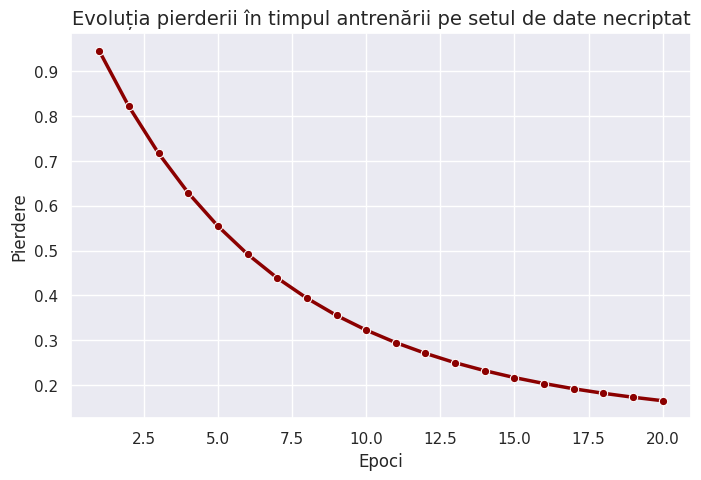

Antrenarea modelului pe date necriptate a durat:1.41430619199945795117 secunde


In [404]:
li_r_model = LinearRegressionFromScratch(n_features=x_train.shape[1])
t_start = time.perf_counter()
batch_size = 512
epochs = 20
loss_list =[]
for epoch in tqdm(range(epochs),desc="epoch"):
    
    indices = np.random.permutation(x_train.shape[0])
    epoch_data = [x_train[idx] for idx in indices]
    epoch_targets = [y_train[idx] for idx in indices]
    predictions = torch.tensor([])
    for batch in range(0, len(epoch_data),batch_size):
        batch_data = epoch_data[batch: batch+batch_size]
        batch_targets = epoch_targets[batch: batch+batch_size]

        batch_out = li_r_model.forward(batch_data)
        li_r_model.backward(batch_data, batch_out, batch_targets)
        li_r_model.update_parameters()
        predictions= torch.cat((predictions , batch_out), dim=0) 
    loss = mean_squared_error(epoch_targets, predictions)
    loss_list.append(loss)
    print(f"Epoch {epoch+1}, Loss: {loss}")
sns.set_theme(style="darkgrid", palette="pastel")
plt.figure(figsize=(8, 5))
sns.lineplot(x=range(1, epochs + 1), y=loss_list, marker='o', linewidth=2.5, color="darkred")
plt.xlabel('Epoci', fontsize=12)
plt.ylabel('Pierdere', fontsize=12)
plt.title('Evoluția pierderii în timpul antrenării pe setul de date necriptat', fontsize=14)
plt.savefig('li_r_loss_curve_training_on_clear_data.png')
plt.show()

t_end = time.perf_counter()

print(f"Antrenarea modelului pe date necriptate a durat:{(t_end - t_start):.20f} secunde")

save_model(li_r_model,'li_r_trained_on_clear_data.pkl')


In [ ]:
def metrici_date_test_clare(model, x, y):
    t_start = time.perf_counter()
    pred = model.forward(x)
    t_end = time.perf_counter()
    print(f"predictiile pe testul de date necriptate au durat:{(t_end - t_start):.20f} secunde")

    r2 = r2_score(y, pred)
    print(f"R^2 Score = {r2:.4f}")
    mse =  mean_squared_error(y, pred)
    print(f"MSE = {mse:.4f}")

    plt.figure(figsize=(10, 6))
    plt.scatter(y, pred, alpha=0.5, color='darkred', label='Predicții vs. Valori Reale')
    plt.plot([min(y), max(y)], [min(y), max(y)], color='blue', linestyle='--', label='Predicții perfecte')
    plt.xlabel('Valori Reale', fontsize=12)
    plt.ylabel('Predicții', fontsize=12)
    plt.title('Valori Reale vs. Predicții', fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(title=f'$R^2 = {r2:.4f}$\nMSE = {mse:.4f}', title_fontsize=12)
    plt.savefig("./li_r_trained_on_clear_data_predictions_on_clear_data.png")
    plt.show()
    return r2,mse

predictiile pe testul de date necriptate au durat:0.01321530199948028894 secunde
Actual values: torch.Size([700, 1])
R^2 Score = 0.8639
MSE = 0.1407


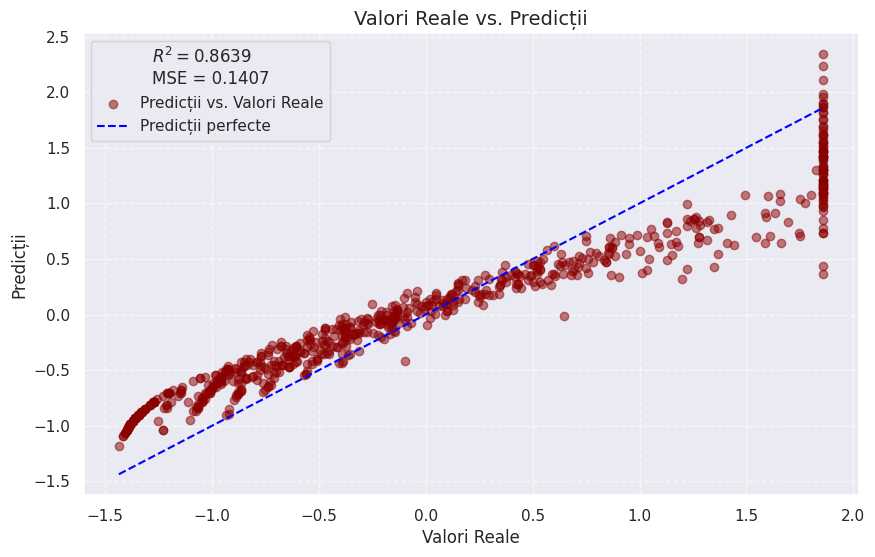

tensor([ 0.3190, -0.0557,  0.1322,  0.1800,  0.1007,  0.1075,  0.1000,  0.1003,
         0.0753,  0.0898,  0.0502,  0.0673,  0.1012,  0.0775,  0.1156,  0.0423])
tensor([0.0121])


In [406]:
# li_r_model = pickle.load(open("./li_r_trained_on_clear_data.pkl", 'rb'))
r2_clear_data, mse_clear_data=metrici_date_test_clare(li_r_model,x_test,y_test)
print(li_r_model.weight)
print(li_r_model.bias)

In [424]:
def importanta_caracteristicilor(model, feature_names):
    weights = model.weight

    weights = torch.abs(weights)
    weights = weights / torch.sum(weights)

    sorted_indices = torch.argsort(weights)
    feature_names_sorted = [feature_names[i] for i in sorted_indices]
    weights_sorted = weights[sorted_indices]

    plt.figure(figsize=(16, 6))
    sns.barplot(y=feature_names_sorted, x=weights_sorted, hue=feature_names_sorted, palette="Reds", orient="h", legend=False)

    plt.xlabel('Importanța caracteristicilor', fontsize=12)
    plt.ylabel('Caracteristici', fontsize=12)
    plt.title('Grafic de importanța caracteristicilor', fontsize=14)

    plt.grid(True, linestyle='--', alpha=0.7)
    plt.savefig("./li_r_trained_on_clear_data_feature_importance.png")
    plt.show()



['age', 'gender', 'chest_pain', 'high_blood_pressure', 'irregular_heartbeat', 'shortness_of_breath', 'fatigue_weakness', 'dizziness', 'swelling_edema', 'neck_jaw_pain', 'excessive_sweating', 'persistent_cough', 'chest_discomfort', 'cold_hands_feet', 'snoring_sleep_apnea', 'anxiety_doom']


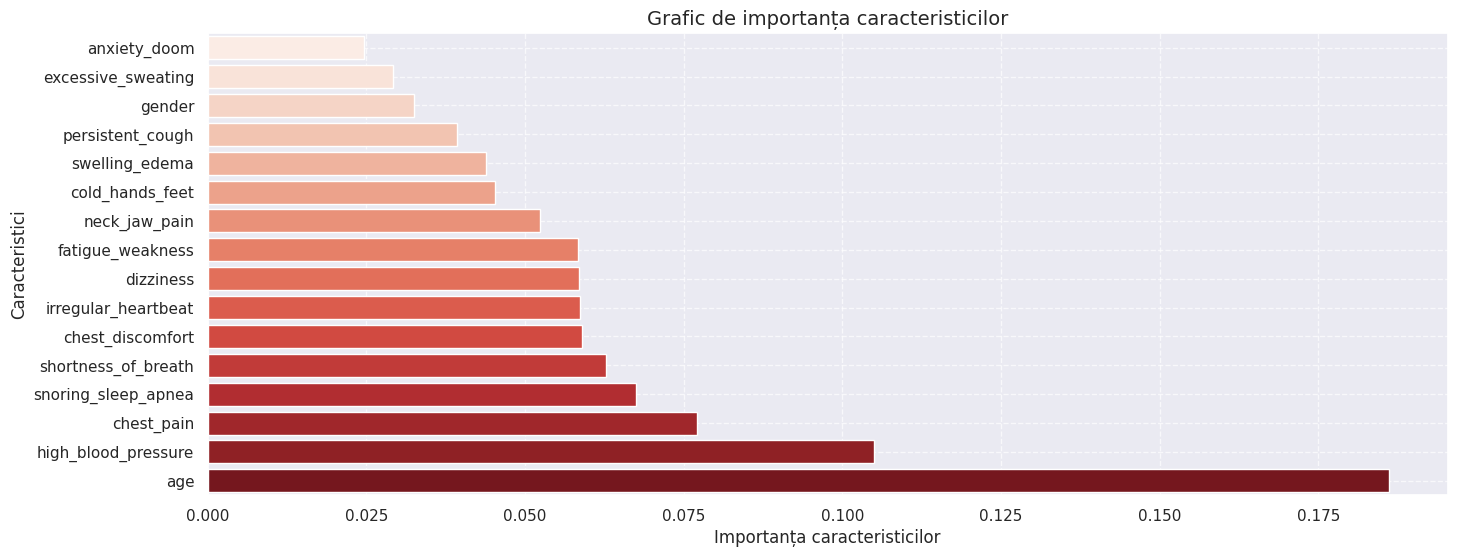

In [425]:
csv = pd.read_csv('./stroke_risk_dataset.csv')
csv = csv.drop(columns=["stroke_risk_percentage", "at_risk", "nausea_vomiting"])
header = csv.columns.tolist()
print(header)
importanta_caracteristicilor(li_r_model,header) 

preziceri pe date criptate

in openfhe exista mai multe security levels care pot fi setate
o sa extragem metrici pentru mai multi parametrii de SetSecurityLevel

In [ ]:
table_list = []

In [426]:
multDepth = 2
scaleModSize = 40
batchSize = len(x_test[1]) #16
parameters = CCParamsCKKSRNS()
parameters.SetMultiplicativeDepth(multDepth)
parameters.SetScalingModSize(scaleModSize)
parameters.SetBatchSize(batchSize)
parameters.SetRingDim(4096)
parameters.SetSecurityLevel(HEStd_NotSet)

cc = GenCryptoContext(parameters)

cc.Enable(PKE)
cc.Enable(KEYSWITCH)
cc.Enable(LEVELEDSHE)
cc.Enable(ADVANCEDSHE)
ring_dim = cc.GetRingDimension()
print(f"Dimensiunea inelului in CKKS {ring_dim}")
security_param= parameters.GetSecurityLevel()
print(f"Parametrul de securitate: {security_param}")
keys = cc.KeyGen()

#asigura ca evaluarea datelor criptate se face fara decriptatea lor
#cheile sunt derivate din secret key
cc.EvalMultKeyGen(keys.secretKey)
cc.EvalSumKeyGen(keys.secretKey)


Dimensiunea inelului in CKKS 4096
Parametrul de securitate: SecurityLevel.HEStd_NotSet


In [432]:
#x_test nu are o forma buna pentru biblioteca openfhe
print(x_test.shape)
x_test_list = x_test[:700].tolist() 
print(x_test_list[:2])
print(type(x_test_list[0]))

torch.Size([700, 16])
[[-0.4856494069099426, -1.00515615940094, -0.4117799401283264, 1.7292275428771973, -0.3283218741416931, -0.48778727650642395, -0.5707517862319946, -0.4851568639278412, -0.41272860765457153, -0.3342396318912506, 3.038736343383789, -0.343669593334198, 2.4405479431152344, -0.4890051484107971, -0.4168514609336853, -0.33037757873535156], [1.2492173910140991, 0.9948703050613403, -0.4117799401283264, 1.7292275428771973, 3.0457913875579834, 2.0500738620758057, 1.7520751953125, 2.0611891746520996, -0.41272860765457153, -0.3342396318912506, -0.3290841579437256, 2.90977144241333, 2.4405479431152344, 2.0449681282043457, -0.4168514609336853, -0.33037757873535156]]
<class 'list'>


In [433]:
def criptare_vector():
    enc_list=[]
    for x_t_l in tqdm(x_test_list, desc="criptare date"):
        x_test_encoded = cc.MakeCKKSPackedPlaintext(x_t_l)
        enc_x_test = cc.Encrypt(keys.publicKey, x_test_encoded)
        enc_list.append(enc_x_test)
    return enc_list

In [434]:
t_start = time.perf_counter()
enc_test_list = criptare_vector()
t_end = time.perf_counter()
print(f"Criptarea pe setul de date de test a durat {(t_end - t_start):.20f} secunde")

criptare date:   0%|          | 0/700 [00:00<?, ?it/s]

criptare date: 100%|██████████| 700/700 [00:03<00:00, 186.54it/s]

Criptarea pe setul de date de test a durat 3.75846689399986644275 secunde


In [449]:
def forward_on_encrypted_data(model,enc_x):
    weight = model.weight.tolist()
    bias = model.bias.tolist()
    #encode weight si bias
    encoded_weights = cc.MakeCKKSPackedPlaintext(weight)
    encoded_bias = cc.MakeCKKSPackedPlaintext(bias)
    enc_sum = cc.EvalInnerProduct(enc_x, encoded_weights,16)
    enc_pred = cc.EvalAdd(enc_sum, encoded_bias)
    return enc_pred

In [451]:
def metrici_date_test_criptate(model, enc_x, y):
    #predictiile sunt se vor intoarce criptate
    enc_list_pred = []
    t_start = time.perf_counter()
    for e_x in tqdm(enc_x, desc="Predictii"):
        pred = forward_on_encrypted_data(li_r_model,e_x)
        enc_list_pred.append(pred)
    t_end = time.perf_counter()
    t_pred = t_end - t_start
    print(f"Predictiile pe testul de date criptat au durat:{(t_end - t_start):.20f} secunde")
    # return enc_list_pred[0]
    #trebuie decriptate pentru a calcula metricile
    list_pred = []
    t_start = time.perf_counter()
    for enc_pred in enc_list_pred:
        decript = cc.Decrypt(enc_pred, keys.secretKey)
        decript.SetLength(1)
        decoded_values = decript.GetCKKSPackedValue()
        list_pred.append(decoded_values[0].real)
    t_end = time.perf_counter()
    t_decrip_pred = t_end - t_start
    print(f"Decriptarea predictiilor a durat:{(t_end - t_start):.20f} secunde")
    
    print(list_pred[0])
    print(list_pred[0].real)
    # list_pred = [x.real for x in list_pred]
    print(list_pred[0])
    y = y.detach().numpy()
    r2 = r2_score(y, list_pred)
    print(f"R^2 Score = {r2:.4f}")
    mse =  mean_squared_error(y, list_pred)
    print(f"MSE = {mse:.4f}")

    plt.figure(figsize=(10, 6))
    plt.scatter(y, list_pred, alpha=0.5, color='darkred', label='Predictii vs. Valori Reale')
    plt.plot([min(y), max(y)], [min(y), max(y)], color='blue', linestyle='--', label='Predictii perfecte')
    plt.xlabel('Valori Reale', fontsize=12)
    plt.ylabel('Predictii', fontsize=12)
    plt.legend(title=f'$R^2 = {r2:.4f}$\nMSE = {mse:.4f}', title_fontsize=12)
    plt.title('Valori Reale vs. Predictii', fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.savefig("./li_r_trained_on_clear_data_predictions_on_encrypted_data.png")
    plt.show()
    return r2
  
    

Predictii: 100%|██████████| 700/700 [00:20<00:00, 34.74it/s]


Predictiile pe testul de date criptat au durat:20.15763127999980497407 secunde
Decriptarea predictiilor a durat:2.51579639900046458934 secunde
0.1939432073970134
0.1939432073970134
0.1939432073970134
R^2 Score = 0.8639
MSE = 0.1407


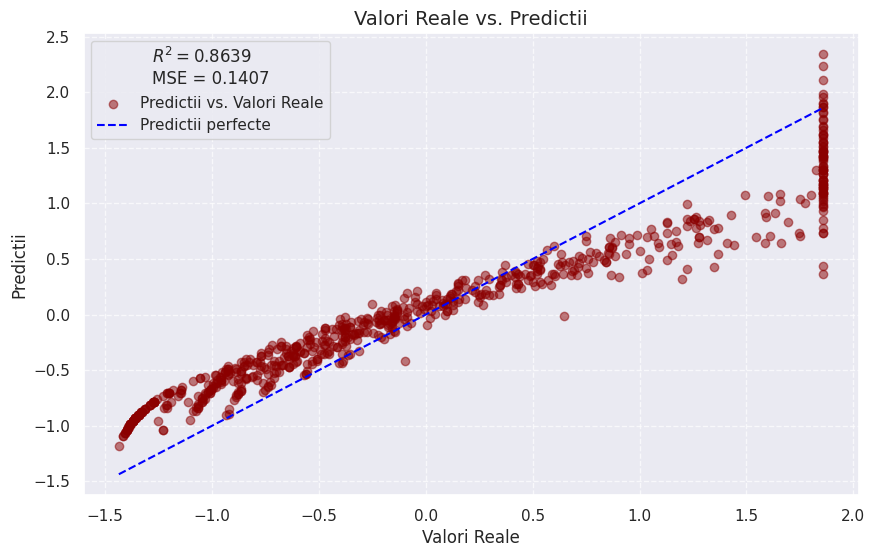

In [452]:
r2 = metrici_date_test_criptate(li_r_model,enc_test_list,y_test)

se vede ca diferenta de precizie este inexistenta intre prezicerile pe date clare si cele pe date criptate

in continuare vom vedea cum criptarea poate sa influenteze precizia si intre ce valori se situeaza de fapt precizia pe datele de test 


In [ ]:
def interval_de_precizie(model, enc_x, y):
     #predictiile sunt se vor intoarce criptate
    enc_list_pred = []
    t_start = time.perf_counter()
    for e_x in tqdm(enc_x, desc="Predictii"):
        pred = forward_on_encrypted_data(model,e_x)
        enc_list_pred.append(pred)
    t_end = time.perf_counter()
    t_pred = t_end - t_start
    print(f"Predictiile pe testul de date criptat au durat:{(t_end - t_start):.20f} secunde")
   
    #trebuie decriptate pentru a calcula metricile
    list_pred = []
    t_start = time.perf_counter()
    for enc_pred in enc_list_pred:
        decript = cc.Decrypt(enc_pred, keys.secretKey)
        decript.SetLength(1)
        decoded_values = decript.GetCKKSPackedValue()
        list_pred.append(decoded_values[0].real)
    t_end = time.perf_counter()
    t_dec_pred = t_end - t_start
    print(f"Decriptarea predictiilor a durat:{(t_end - t_start):.20f} secunde")
    
    y = y.detach().numpy()
    r2 = r2_score(y, list_pred)
    print(f"R^2 Score = {r2:.4f}")
    mse =  mean_squared_error(y, list_pred)
    print(f"MSE = {mse:.4f}")
    return r2, mse, t_pred, t_dec_pred

In [ ]:
mse_list = []
r2_list = []
sum_timp_criptare = 0
sum_timp_pred = 0
sum_timp_dec_pred =0
for incercari in range(5):
    t_start = time.perf_counter()
    enc_x_test = criptare_vector()
    t_end = time.perf_counter()
    t_cript = t_end-t_start
    sum_timp_criptare +=t_cript
    r2,mse,t_pred, t_dec_pred = interval_de_precizie(li_r_model,enc_x_test,y_test[:700])
    sum_timp_pred +=t_pred
    sum_timp_dec_pred += t_dec_pred
    mse_list.append(mse)
    r2_list.append(r2)

avg_timp_criptare = sum_timp_criptare/5
avg_timp_pred = sum_timp_pred/5
avg_timp_dec_pred = sum_timp_dec_pred /5

In [ ]:
data = {
    'Iterație': [i for i in range(5)],
    'R2 Date Criptat': r2_list,
    'R2 Date clare': [r2_clear_data] * 5, 
}

df = pd.DataFrame(data)

plt.figure(figsize=(10, 6))

sns.lineplot(data=df, x='Iterație', y='R2 Date Criptat', label='R2 date criptate', marker='o', color='red')
sns.lineplot(data=df, x='Iterație', y='R2 Date clare', label='R2 date clare', marker='x', color='orange')


plt.title('Variația R2 în cele 5 criptări de date')
plt.xlabel('Iterație')
plt.ylabel('Valori')

y_ticks = [ 0.85,0.851,0.852,0.853,0.854,0.855,0.856,0.859]
plt.yticks(y_ticks)

plt.ylim(0.849, 0.859)  

plt.legend()

plt.savefig("li_r_trained_on_clear_data_variance_predictions_on_encrypted_data.png")

plt.show()
    

In [ ]:
# (security_param,ring_dim,avg_timp_criptare,avg_timp_pred,avg_timp_dec_pred,r2)

(<SecurityLevel.HEStd_128_classic: 0>,
 16384,
 12.626807427800667,
 49.710884650399386,
 8.885370516202238,
 0.8281465457088487)

In [ ]:
# table_list.append((security_param,ring_dim,avg_timp_criptare,avg_timp_pred,avg_timp_dec_pred,r2))
# print(table_list)